# Домашнее задание 1: Анализ данных по коронавирусу

In [6]:
# Загрузка данных
import pandas as pd
import numpy as np
df = pd.read_csv("owid-covid-data.csv", parse_dates = True)

1. Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания). Иначе говоря, мы будем “играть” за российские власти, которые пытаются понять, что делать, глядя на данные об эпидемии в мае 2020 года.

In [9]:
df.loc[:, 'new_cases'] = np.where(df['new_cases'] < 1, 1, df['new_cases'])
df = df[(df['location'] == 'Russia') & (df['date'] > '2020-03-01')].reset_index(drop=True)
df['day'] = df.index + 1
train = df.iloc[:50, :]
train.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,day
0,RUS,Europe,Russia,2020-03-02,3.0,1.0,0.143,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,1
1,RUS,Europe,Russia,2020-03-03,3.0,1.0,0.143,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,2
2,RUS,Europe,Russia,2020-03-04,3.0,1.0,0.143,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,3
3,RUS,Europe,Russia,2020-03-05,4.0,1.0,0.286,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,4
4,RUS,Europe,Russia,2020-03-06,13.0,9.0,1.571,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,5


2. Постройте графики целевых переменных

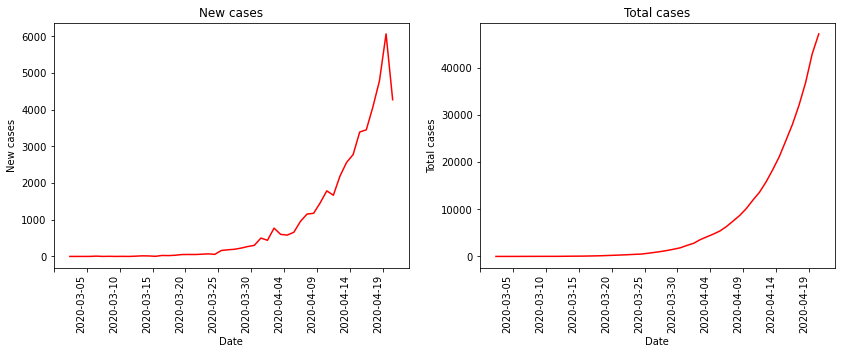

In [16]:
import matplotlib.pyplot as plt
fig, axis = plt.subplots(figsize=(14, 5), nrows=1, ncols=2)
fig.autofmt_xdate(rotation=90)

axis[0].plot(train["date"], train["new_cases"], color="red")
axis[0].set_xlabel("Date")
axis[0].set_ylabel("New cases")
axis[0].set_title("New cases")
start, end = axis[0].get_xlim()
axis[0].xaxis.set_ticks(np.arange(start, end, 5))

axis[1].plot(train["date"], train["total_cases"], color="red")
axis[1].set_xlabel("Date")
axis[1].set_ylabel("Total cases")
axis[1].set_title("Total cases")
start, end = axis[1].get_xlim()
axis[1].xaxis.set_ticks(np.arange(start, end, 5))

plt.show()

2a. Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

In [21]:
from sklearn.linear_model import LinearRegression
train_size = 50
train = df[:train_size]
test =  df[train_size:]

test_size = 20
x_train, y_train = train["day"].values.reshape(-1, 1), np.log(train["total_cases"])
x_test, y_test = test["day"][:test_size].values.reshape(-1, 1), test["total_cases"][:test_size]
model = LinearRegression()
model.fit(x_train, y_train)
preds = np.exp(model.predict(x_test))

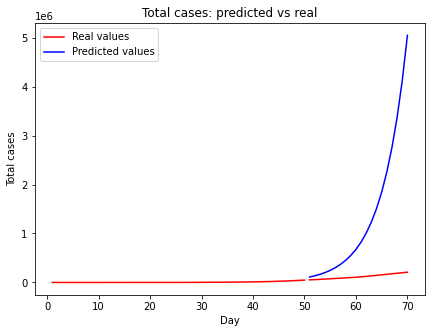

In [37]:
_, ax = plt.subplots(figsize=(7, 5))
ax.plot(train["day"], train["total_cases"], label="Real values", color="red")
ax.plot(test["day"][:test_size], test["total_cases"][:test_size], color="red")
ax.plot(test["day"][:test_size], preds, label="Predicted values", color="blue")
plt.xlabel("Day")
plt.ylabel("Total cases")
plt.title("Total cases: predicted vs real")
plt.legend()
plt.show()

2b. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

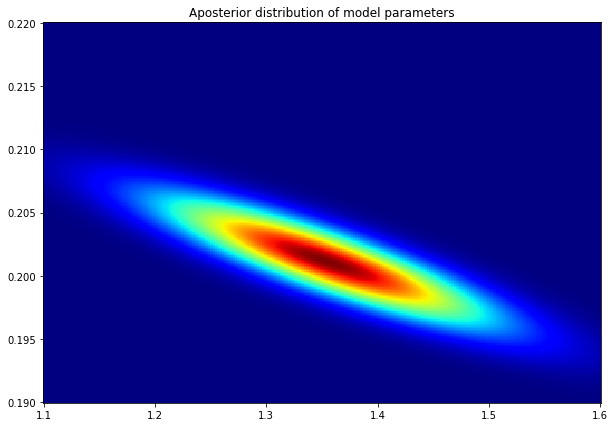

In [67]:
from scipy.stats import multivariate_normal

def get_noise_var(real_values, train_preds):
    return (real_values - train_preds).var()
noise_var = get_noise_var(np.log(train["total_cases"]), model.predict(x_train))

mu0, sigma0 = np.array([0, 0]), 100 * np.array([[1, 0], [0, 1]])

X = np.hstack((np.ones((len(x_train), 1)), x_train))
def bayesian_update(mu0, sigma0, x, y, noise_var):
    sigma = np.linalg.inv(np.linalg.inv(sigma0) + (1 / noise_var) * np.transpose(x) @ x)
    mu = np.matmul(sigma, np.matmul(np.linalg.inv(sigma0), np.transpose(mu0)) + (1 / noise_var) * np.matmul(np.transpose(x), y))
    return mu, sigma
mu, sigma = bayesian_update(mu0, sigma0, X, y_train, noise_var)

def plot_posterior(X, Y, mu, sigma):
    Т = 1000
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    Z = multivariate_normal.pdf(pos, mean=mu, cov=sigma)
    plt.figure(figsize=(10, 7))
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet, shading='auto')
    plt.title('Aposterior distribution of model parameters')
    plt.show()
    
N = 250
X = np.linspace(1.1, 1.6, N)
Y = np.linspace(0.19, 0.22, N)
X, Y = np.meshgrid(X, Y)
plot_posterior(X, Y, mu, sigma)

2c. Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая
2020 года? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

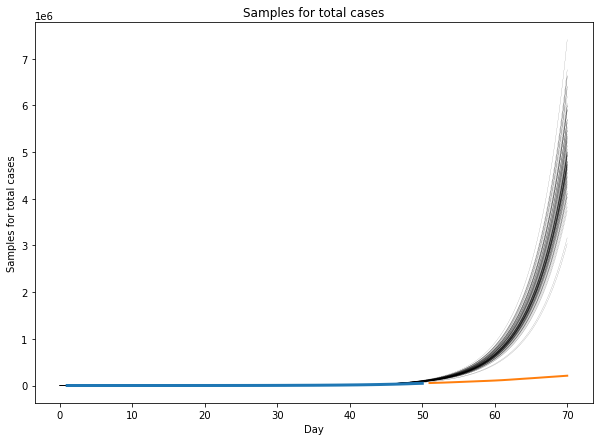

In [65]:
n_samples = 100

weights = np.random.multivariate_normal(mu, sigma, n_samples)

def plot_samples(weights, target, title, func, n_samples=100):
    xs = np.linspace(0, train_size + test_size, N)
    plt.figure(figsize=(10, 7))
    for w in weights:
        plt.plot(xs, np.exp(func(w, xs)), 'k-', linewidth=.1)
    plt.plot(train["day"], train[target], label="Train values",  linewidth=3)
    plt.plot(test["day"][:test_size], test[target][:test_size], label="Test values",  linewidth=2)
    plt.xlabel("Day")
    plt.ylabel(title)
    plt.title(title)
    plt.show()

def linear(weights, x):
    return weights[0] + weights[1] * x

plot_samples(weights, "total_cases", "Samples for total cases", linear)

In [63]:
start_date = pd.to_datetime("2020-03-03")

def get_prediction(date, model=model, start_date=start_date):
    return int(np.exp(model.predict(np.array((pd.to_datetime(date) - start_date).days + 1).reshape(-1, 1))))

print("Estimated total cases up to:")
print("May 1st, 2020:      ", get_prediction("2020-05-01"))
print("June 1st, 2020:     ", get_prediction("2020-06-01"))
print("September 1st, 2020:", get_prediction("2020-09-01"))

Estimated total cases up to:
May 1st, 2020:       675344
June 1st, 2020:      344833158
September 1st, 2020: 37540767230946800


Впечатляющий прогноз, но, увы, далекий от реальности.

D:\work\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


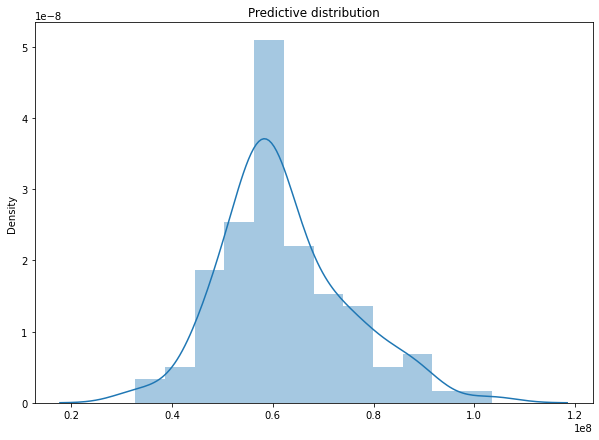

In [70]:
import seaborn as sns

n_samples = 1000

def plot_preds(x, n_samples, weights):
    x_b = np.hstack((np.ones((len(x), 1)), x))
    preds = []
    for w in weights:
        preds.append(np.exp(np.matmul(x_b, w)))
    plt.figure(figsize=(10, 7))
    sns.distplot(np.array(preds).mean(axis=1)).set_title("Predictive distribution")
    
start = test_size + train_size
x = np.arange(start, start + 20, 1).reshape(-1, 1)
plot_preds(x, n_samples, weights)    